# Test for consensus
This notebook documents the node-side implementation for the consensus test.
This experiment utilizes processes as computing nodes.
For deploying nodes across multiple machines, refer to the [sync experiment](https://github.com/rui-huang-opt/topolink/tree/master/examples/sync) for implementation examples.

## 1. Set some global parameters:

In [7]:
if __name__ == "__main__":
    import os

    RESULTS_PATH = os.path.join(os.getcwd(), "results")
    os.makedirs(RESULTS_PATH, exist_ok=True)

    N_STATE = 3
    N_NODES = 5

## 2. Deploy the nodes using multiprocessing:

In [8]:
from multiprocessing import Pool


def gossip(name: str, n_state: int, results_path: str, n_iter: int = 100) -> None:
    from numpy import zeros, save
    from numpy.random import uniform, seed
    from topolink import NodeHandle

    nh = NodeHandle(name=name, server_address="localhost:5555")

    states = zeros((n_iter, n_state))
    seed(int(name))  # Ensure reproducibility for each node
    states[0] = uniform(-100.0, 100.0, n_state)

    for k in range(n_iter - 1):
        laplacian = nh.compute_laplacian(states[k])
        states[k + 1] = states[k] - 0.45 * laplacian

    save(os.path.join(results_path, f"{name}.npy"), states)


if __name__ == "__main__":

    def execute_nodes(n_nodes: int, n_state: int, results_path: str) -> None:
        node_args = [(f"{i + 1}", n_state, results_path) for i in range(n_nodes)]

        with Pool() as pool:
            pool.starmap(gossip, node_args)

    execute_nodes(N_NODES, N_STATE, RESULTS_PATH)

**Note:**
The order in which the nodes and server are started does not affect the overall program.

## 3. Plot the results:

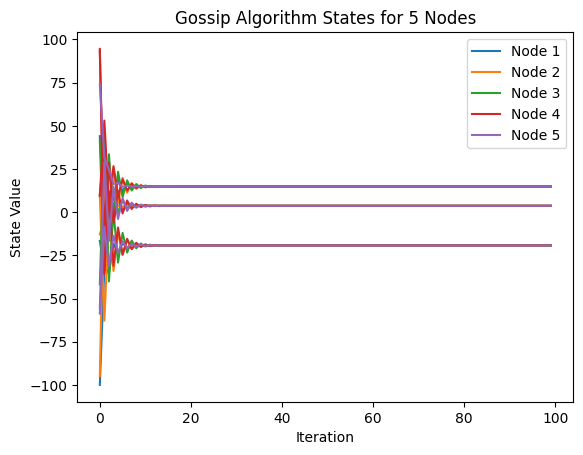

In [9]:
def plot_results(n_nodes: int, n_state: int, results_path: str) -> None:
    from numpy import load

    node_states = {
        f"{i + 1}": load(os.path.join(results_path, f"{i + 1}.npy"))
        for i in range(n_nodes)
    }

    import matplotlib.pyplot as plt

    _, ax = plt.subplots()

    colors = {
        "1": "tab:blue",
        "2": "tab:orange",
        "3": "tab:green",
        "4": "tab:red",
        "5": "tab:purple",
    }

    for i, states in node_states.items():
        for j in range(n_state):
            (line,) = ax.plot(states[:, j], color=colors[i])
            line.set_label(f"Node {i}") if j == 0 else None

    ax.set_xlabel("Iteration")
    ax.set_ylabel("State Value")
    ax.legend()
    ax.set_title(f"Gossip Algorithm States for {n_nodes} Nodes")

    plt.show()


if __name__ == "__main__":
    plot_results(N_NODES, N_STATE, RESULTS_PATH)